# Exploratory Solar Data Analysis
Exploratory data analysis (EDA) is an essential step in understanding and interpreting data in any scientific field. In the case of solar power plants, EDA can help identify trends, patterns, and anomalies that could impact plant performance and ultimately affect energy production. By analyzing data collected from various sources such as weather stations, sensors, and power meters, EDA can provide insights into the plant's performance, efficiency, and reliability. In this way, EDA can play a critical role in optimizing solar power plant operations and maintenance, ensuring that they are cost-effective, sustainable, and environmentally friendly.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
#xformatter = mdates.DateFormatter('%H:%M')
sns.set_style("darkgrid")
sns.set_context("paper")
#sns.set(rc={'figure.figsize':(11.7,8.27)})

Next, we will read the file containing information about the power generation plant. The following columns can be found:

DATE_TIME: Temporal data that indicates the time when the measurement was taken.
PLANT_ID: The identification of the plant, which is the same throughout the entire file.
SOURCE_KEY: ID of the inverter.
DC_POWER: Amount of direct current generated in a 15-minute period, measured in kW.
AC_POWER: Amount of alternating current generated in a 15-minute period, measured in kW.
DAILY_YIELD: Amount of daily energy accumulated up to that point in time.
TOTAL_YIELD: Amount of energy accumulated in that inverter up to that point in time.




In [2]:
plant = 'Plant_2'
filename = 'archive/' + plant + '_Generation_Data.csv'
df = pd.read_csv(filename)

if df.isnull().sum().sum() == 0 and df.duplicated().sum() == 0:
    print("There are no missing or duplicates values in the dataset.")
else:
    print("There are missing or duplicates in the dataset.")
    df = df.drop_duplicates()
    print("Dropped!")

df.fillna(0, inplace=True)

There are no missing or duplicates values in the dataset.


In [3]:
# Convert the 'DATE_TIME' column to datetime format
if plant == 'Plant_1':
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%d-%m-%Y %H:%M')
elif plant == 'Plant_2':
    df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
# Check for timezone inconsistencies
if df['DATE_TIME'].dt.tz is None:
    # Set timezone to a consistent value
    df['DATE_TIME'] = df['DATE_TIME'].dt.tz_localize('UTC')
    print("There are inconsistencies.")
else:
    print("There are no inconsistencies.")

df['TIME'] = df['DATE_TIME'].dt.time
df['DATE'] = df['DATE_TIME'].dt.date

There are inconsistencies.


Next, we will read the file containing information about the power generation plant. The following columns can be found:

DATE_TIME: Temporal data that indicates the time when the measurement was taken.
PLANT_ID: The identification of the plant, which is the same throughout the entire file.
SOURCE_KEY: ID of the inverter.
AMBIENT_TEMPERATURE: Ambient temperature of the location, assumed to be in °C.
MODULE_TEMPERATURE: Temperature of the solar panel module, assumed to be in °C.
IRRADIATION: Corresponds to the radiation in the area, measured in kW/m2.

In [4]:
filename = 'archive/' + plant + '_Weather_Sensor_Data.csv'
df_plant = pd.read_csv(filename)
df_plant.head()
if df_plant.isnull().sum().sum() == 0 and df_plant.duplicated().sum() == 0:
    print("There are no missing or duplicates values in the dataset.")
else:
    print("There are missing or duplicates in the dataset.")
    df_plant = df_plant.drop_duplicates()
    print("Dropped!")

df_plant.fillna(0, inplace=True)

There are no missing or duplicates values in the dataset.


In [5]:
# Convert the 'DATE_TIME' column to datetime format
df_plant['DATE_TIME'] = pd.to_datetime(df_plant['DATE_TIME'], format='%Y%m%d %H:%M:%S')
# Check for timezone inconsistencies
if df_plant['DATE_TIME'].dt.tz is None:
    # Set timezone to a consistent value
    df_plant['DATE_TIME'] = df_plant['DATE_TIME'].dt.tz_localize('UTC')
    print("There are inconsistencies.")
else:
    print("There are no inconsistencies.")

df_plant['TIME'] = df_plant['DATE_TIME'].dt.time
df_plant['DATE'] = df_plant['DATE_TIME'].dt.date

There are inconsistencies.


In [6]:
# Handle missing values
df_plant.fillna(0, inplace=True)

In [7]:
df = pd.merge(df.drop(['PLANT_ID'], axis=1), df_plant.drop(['TIME', 'DATE', 'PLANT_ID', 'SOURCE_KEY'], axis=1), on='DATE_TIME')

In [8]:
# Set the index of the DataFrame to the 'DATE_TIME' column
df.set_index('DATE_TIME', inplace=True)

# Resample the DataFrame to hourly intervals and calculate the mean values
df_hourly = df.resample('H').mean()[["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]]

# Reset the index of the DataFrame to make the 'DATE_TIME' column a regular column again
df_hourly.reset_index(inplace=True)

# Print a message indicating that the data has been aggregated to hourly intervals
print("Done.")

Done.


/var/folders/nf/gc0__kh133b5ml5907fvy1xh0000gn/T/ipykernel_45028/3426630359.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hourly = df.resample('H').mean()[["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]]


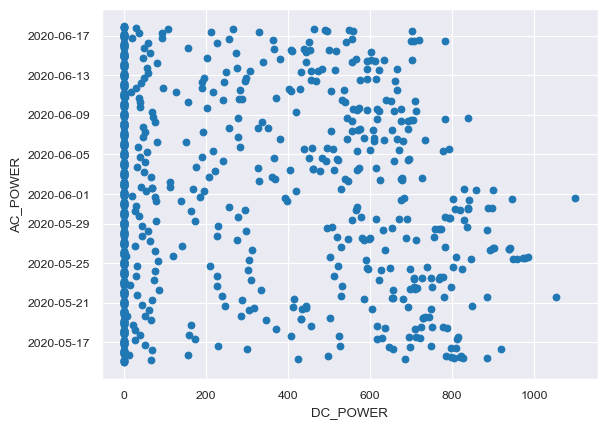

In [9]:
# Scatter plots
plt.scatter(df_hourly['DC_POWER'], df_hourly['DATE_TIME'])
plt.xlabel('DC_POWER')
plt.ylabel('AC_POWER')
plt.show()

In [10]:
df = df.reset_index()

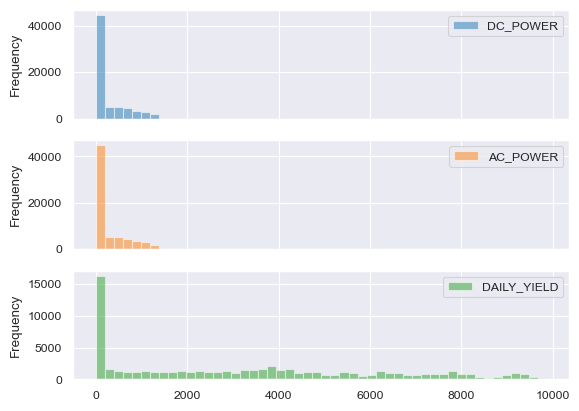

In [11]:
# Histograms of 'DC_POWER', 'AC_POWER', 'DAILY_YIELD'
df[['DC_POWER', 'AC_POWER', 'DAILY_YIELD']].plot(kind='hist', bins=50, alpha=0.5, subplots=True)
plt.show()

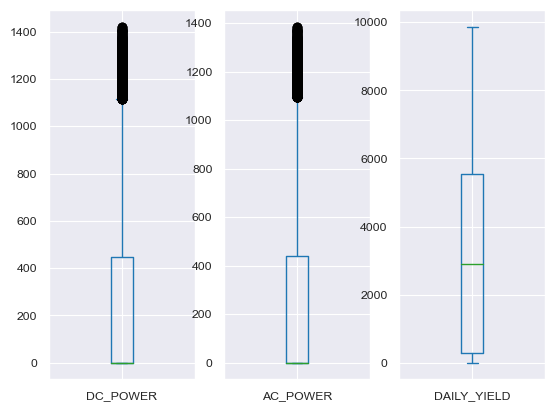

In [12]:
# Boxplots of 'DC_POWER', 'AC_POWER', 'DAILY_YIELD'
df[['DC_POWER', 'AC_POWER', 'DAILY_YIELD']].plot(kind='box', subplots=True)
plt.show()

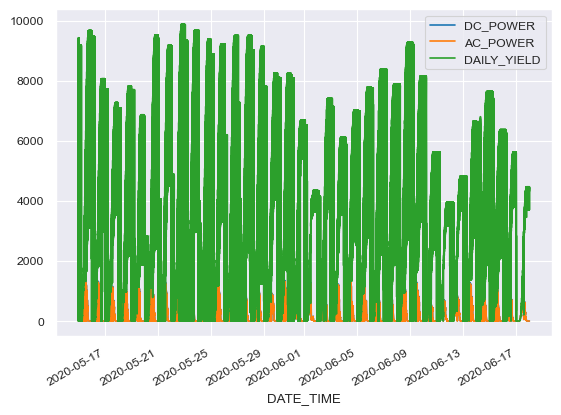

In [13]:
# Line plot of 'DC_POWER', 'AC_POWER', 'DAILY_YIELD' over time
df.plot(x='DATE_TIME', y=['DC_POWER', 'AC_POWER', 'DAILY_YIELD'], kind='line')
plt.show()

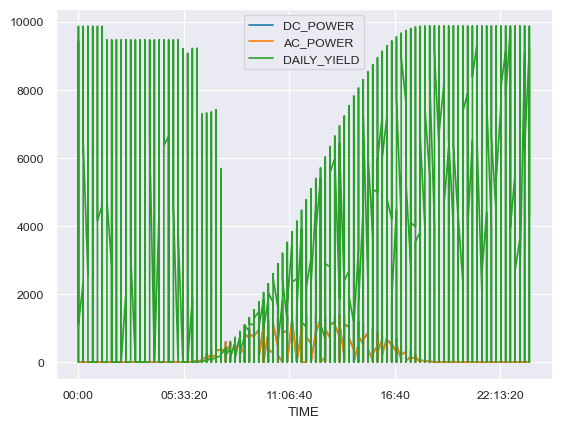

In [14]:
# Line plot of 'DC_POWER', 'AC_POWER', 'DAILY_YIELD' over time
df.plot(x='TIME', y=['DC_POWER', 'AC_POWER', 'DAILY_YIELD'], kind='line')
plt.show()

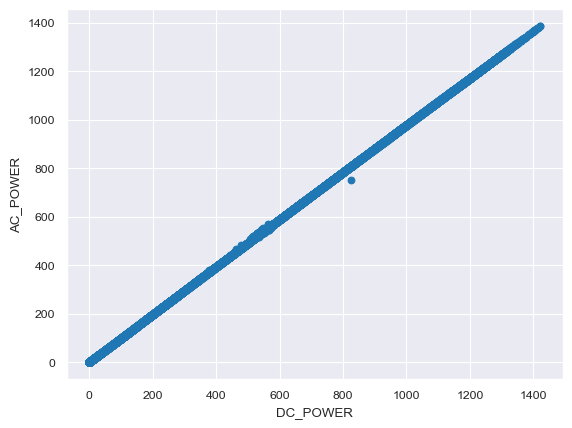

In [15]:
# Scatter plots
plt.scatter(df['DC_POWER'], df['AC_POWER'])
plt.xlabel('DC_POWER')
plt.ylabel('AC_POWER')
plt.show()

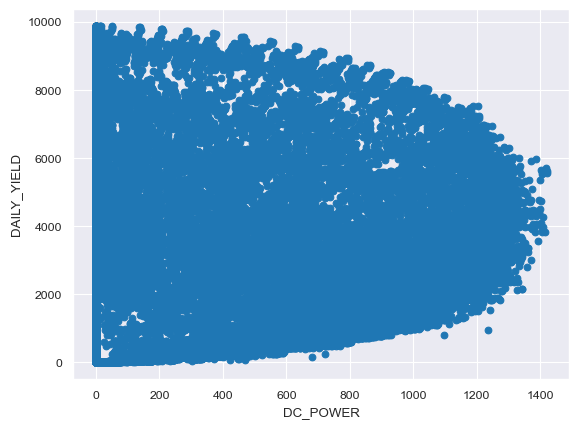

In [16]:
plt.scatter(df['DC_POWER'], df['DAILY_YIELD'])
plt.xlabel('DC_POWER')
plt.ylabel('DAILY_YIELD')
plt.show()

A continuación se hará la lectura del archivo que contiene la información de la planta de generación. En ella encontraremos las siguientes columnas:
- **DATE_TIME**: Dato temporal, indica el tiempo en el cual se realizó la medición.
- **PLANT_ID**: La identificación de la planta, por ende, en todo el archivo es igual.
- **SOURCE_KEY**: ID del inversor.
- **AMBIENT_TEMPERATURE**: Temperatura ambiente del lugar, por las unidades se asume en °C.
- **MODULE_TEMPERATURE**: Temperatura del modulo del panel solar, por las unidades se asume en °C.
- **IRRADIATION**: Corresponde a la radiación en la zona, medido en kW/m2.


In [17]:
filename = 'archive/' + plant + '_Weather_Sensor_Data.csv'
df_plant = pd.read_csv(filename)
df_plant.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0


In [18]:
# Convert the 'DATE_TIME' column to datetime format
df_plant['DATE_TIME'] = pd.to_datetime(df_plant['DATE_TIME'], format='%Y%m%d %H:%M:%S')
df_plant['TIME'] = df_plant['DATE_TIME'].dt.time
df_plant['DATE'] = df_plant['DATE_TIME'].dt.date

In [19]:
# Handle missing values
df_plant.fillna(0, inplace=True)

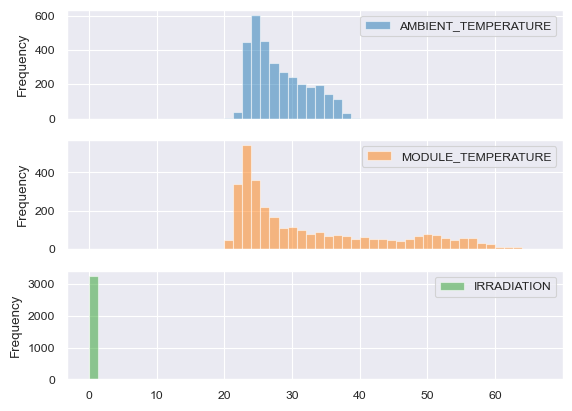

In [20]:
# Histograms of 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'
df_plant[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].plot(kind='hist', bins=50, alpha=0.5, subplots=True)
plt.show()

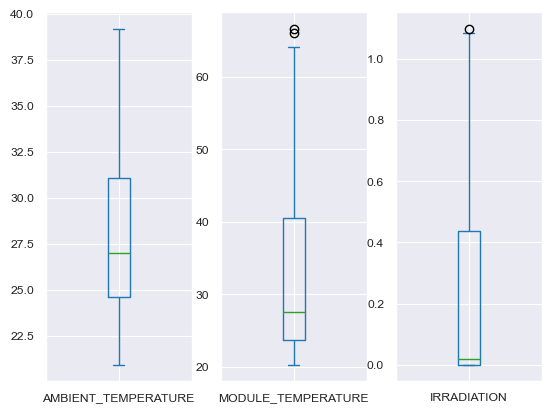

In [21]:
# Boxplots of 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'
df_plant[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].plot(kind='box', subplots=True)
plt.show()

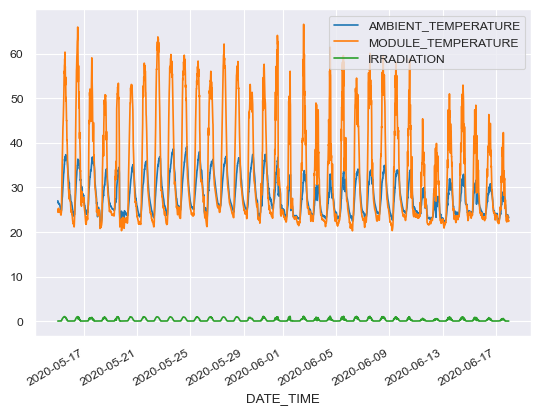

In [22]:
# Line plot of 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION' over time
df_plant.plot(x='DATE_TIME', y=['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'], kind='line')
plt.show()

In [23]:
df1 = pd.read_csv('archive/Plant_1_Generation_Data.csv')
df1 = df1[['DATE_TIME', 'DC_POWER', 'AC_POWER']].set_index('DATE_TIME').add_suffix('_Plant1').reset_index()
df1['DATE_TIME'] = pd.to_datetime(df1['DATE_TIME'], format='%d-%m-%Y %H:%M')

df2 = pd.read_csv('archive/Plant_2_Generation_Data.csv')
df2 = df2[['DATE_TIME', 'DC_POWER', 'AC_POWER']].set_index('DATE_TIME').add_suffix('_Plant2').reset_index()
df2['DATE_TIME'] = pd.to_datetime(df2['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

df_plants = df1.merge(df2, on='DATE_TIME', how='left')
df_plants['TIME'] = df_plants['DATE_TIME'].dt.time
df_plants['DATE'] = df_plants['DATE_TIME'].dt.date

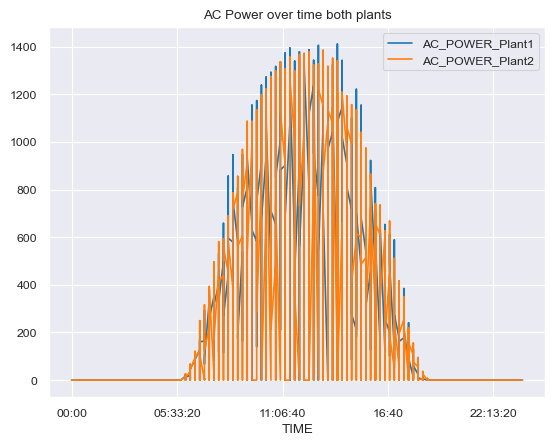

In [24]:
df_plants.plot(x='TIME', y=['AC_POWER_Plant1', 'AC_POWER_Plant2'], kind='line')
plt.title(f"AC Power over time both plants")
plt.savefig(f"AC-power_by_time.jpg")
plt.show()

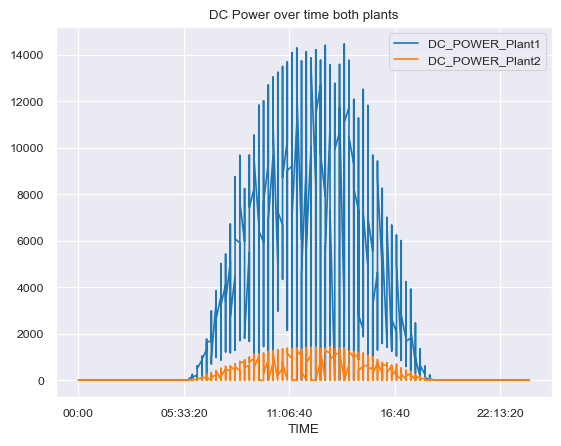

In [25]:
# Line plot of 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION' over time
df_plants.plot(x='TIME', y=['DC_POWER_Plant1', 'DC_POWER_Plant2'], kind='line')
plt.title(f"DC Power over time both plants")
plt.savefig(f"DC-power_by_time.jpg")
plt.show()

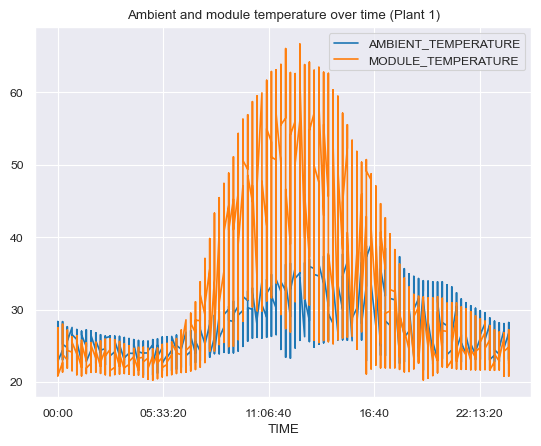

In [26]:
df.plot(x='TIME', y=['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE'], kind='line')
plt.title(f"Ambient and module temperature over time (Plant 1)")
plt.savefig(f"temperature_time.jpg")
plt.show()

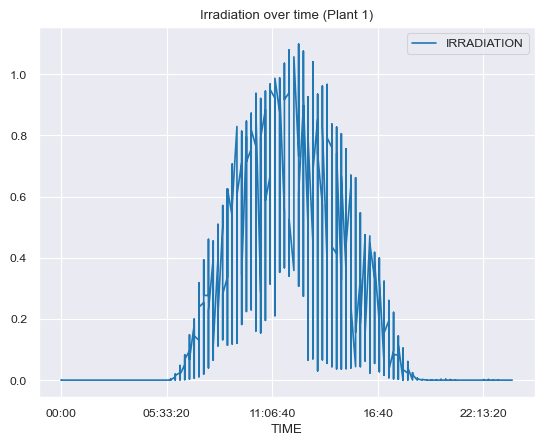

In [27]:
# Line plot of 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION' over time
df.plot(x='TIME', y=['IRRADIATION'], kind='line')
plt.title(f"Irradiation over time (Plant 1)")
plt.savefig(f"irradiation_time.jpg")
plt.show()

In [28]:
# Basic statistics
print(df_plant[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].describe())

       AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
count          3259.000000         3259.000000  3259.000000
mean             28.069400           32.772408     0.232737
std               4.061556           11.344034     0.312693
min              20.942385           20.265123     0.000000
25%              24.602135           23.716881     0.000000
50%              26.981263           27.534606     0.019040
75%              31.056757           40.480653     0.438717
max              39.181638           66.635953     1.098766


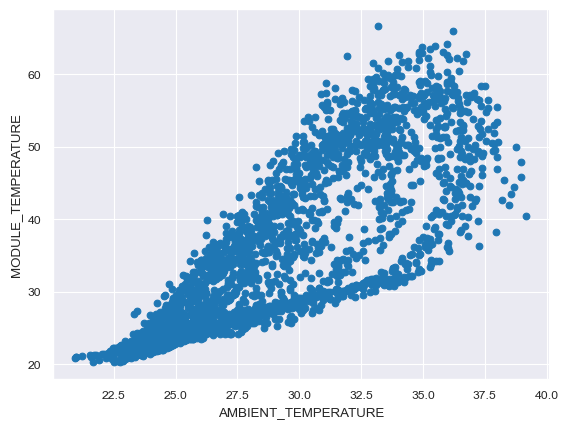

In [29]:
# Scatter plots
plt.scatter(df_plant['AMBIENT_TEMPERATURE'], df_plant['MODULE_TEMPERATURE'])
plt.xlabel('AMBIENT_TEMPERATURE')
plt.ylabel('MODULE_TEMPERATURE')
plt.show()

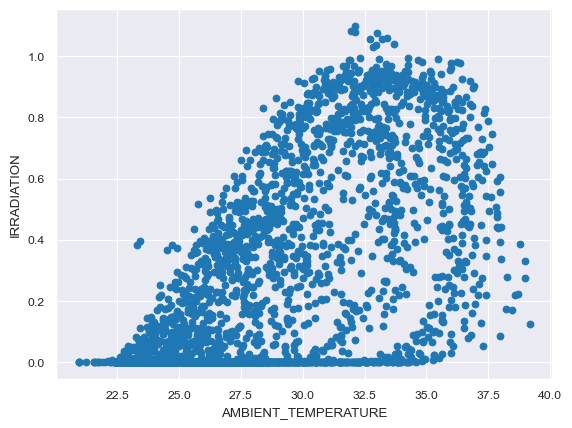

In [30]:
plt.scatter(df_plant['AMBIENT_TEMPERATURE'], df_plant['IRRADIATION'])
plt.xlabel('AMBIENT_TEMPERATURE')
plt.ylabel('IRRADIATION')
plt.show()

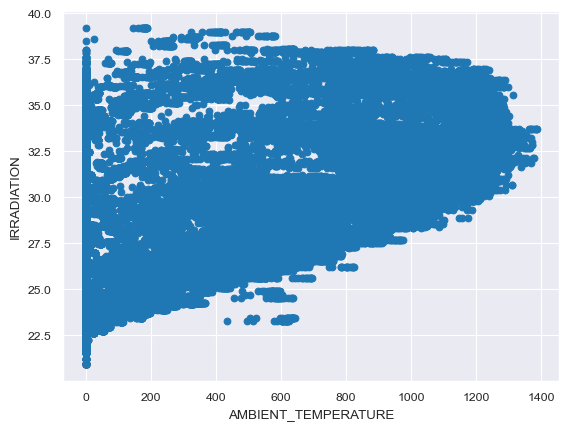

In [31]:
plt.scatter(df['AC_POWER'], df['AMBIENT_TEMPERATURE'])
plt.xlabel('AMBIENT_TEMPERATURE')
plt.ylabel('IRRADIATION')
plt.show()

In [32]:
# Create a new dataframe with only the 'DATE_TIME' and 'DC_POWER' columns
df_power = df.reset_index()

In [33]:
# Set the 'DATE_TIME' column as the index of the dataframe
df_power.set_index('DATE_TIME', inplace=True)

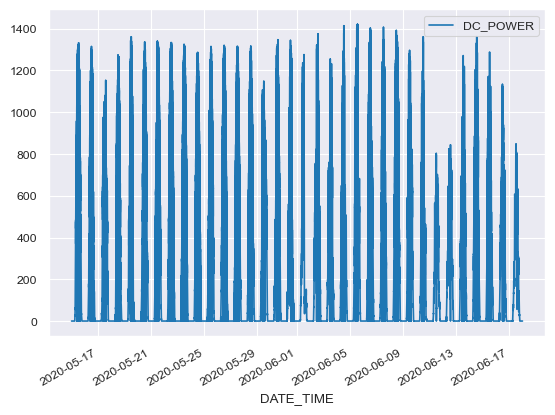

In [34]:
# Visualize the time series data
df_power.plot(y='DC_POWER')
plt.show()

Es posible ver que existen correlaciones entre varias variables, por lo que se podría crear un modelo de regresión para estimar la generación del panel a partir de algún elemento medioambiental (como temperatura ambiente). También podríamos intentar predecir la generación futura de los paneles a partir de la generación histórica (son dos formas de abordar el problema, veamos cual tiene un mejor comportamiento).

In [35]:
filename = 'Data/' + plant + '_wraped.csv'
df.to_csv(filename, index=False)